In [4]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
#from problem import ProblemES
from multiprocessing.pool import ThreadPool
import logging
logging.basicConfig(level=logging.ERROR)
from time import time

N_INDIV= 150
N_GEN = 75
DAYS= 14
START_DAY = 60
#pool = ThreadPool(N_INDIV)


In [5]:
import numpy as np
from pymoo.core.problem import Problem

from district import Scenarios, calculate_kpis, create_energy_system, post_process_results, solve_model
from prepare_district_data import prepare_district_dataframe
from oemof.solph import Model
import pandas as pd


class ProblemES(Problem):
    year = 2020
    start_day = 0
    days = 365
    boundary_data = None
    es_size = None
    results_ = []
    scenario = Scenarios.PV_WIND
    generation = 0
    kpis_names = None

    def __init__(self):
        super().__init__(n_var=4,
                         n_obj=2,
                         xl=0.0,
                         xu=400.0)
        
    def build_boundary_data(self):
        boundary_data_year = prepare_district_dataframe(year=self.year)
        boundary_data = boundary_data_year.tail(365*24-self.start_day*24)
        boundary_data = boundary_data.head(self.days * 24)

        self.boundary_data=boundary_data

    def _evaluate(self, X, out, *args, **kwargs):
        s= time()
        if self.boundary_data is None:
            self.build_boundary_data()

        f1_ = []
        f2_ = []
        def eval_x_es(x):
            sizing = dict()
            sizing["PV"] = x[0]   # kW
            sizing["WT"] = x[1]   # kW
            sizing["Boiler"] = {"Power": max(300-x[2],10),  # kW
                                "Eff": 0.85,  # 1
                                }
            sizing["P2H"] =  x[2] # kW
            sizing["Battery"] = {
                "Input_Power": x[3]/10,  # kW
                "Output_Power": x[3]/10,  # kW
                "Self_Discharge": 0.01,  # 1
                "Capacity": x[3],  # kWh
                "Eff_Inflow": 0.98,  # 1
                "Eff_Outflow": 0.98,  # 1
            }

            try:
                energy_system = create_energy_system(
                    self.boundary_data, scenario=self.scenario, sizing=sizing)
                model = Model(energy_system)
                solved_energy_system = solve_model(model)
                results_sim = post_process_results(solved_energy_system)
                kpis = calculate_kpis(
                    results_sim, self.boundary_data, sizing=sizing, scenario=self.scenario)

                f1 = kpis["total_co2"]
                f2 = kpis["total_system_costs"]
                f3 = kpis["ex_el_fraction"] 
                if self.generation==0 and self.kpis_names is None:
                    self.kpis_names = [x for x in kpis.keys()]
                kpi_val= [k for k in kpis.values()]
            except Exception as e:
                kpi_val = [1000000000]*8 #len(self.kpis_names)
                f1= 1000000000
                f2 = 1000000000
                f3 = 1000000000
            self.results_.append([self.generation+1] + [g for g in x] + kpi_val)
            #print(f"G: {self.generation}, CO2: {f1}, Cost: {f2}")
            return f1,f2,f3
        
        params = [[X[k]] for k in range(len(X))]

        pool = ThreadPool(N_INDIV)
        F= pool.starmap(eval_x_es, params)
        # f1_.append(f1)
        # f2_.append(f2)
        
        
        self.generation += 1
        f1_ = [F[i][0] for i in range(len(F))]
        f2_ = [F[i][1] for i in range(len(F))]
        f3_=[F[i][2] for i in range(len(F))]

        if self.n_obj==2:
            out["F"] = np.column_stack([f1_, f2_])
        elif self.n_obj==3:
            out["F"] = np.column_stack([f1_, f2_,f3_])


        pool.close()
        e= time()
        duration = round(e-s,1)

        print(f"Generation {self.generation} completed in {duration} s.", end = "\r" )

    def finalize(self, filename = "data.csv"):
        data = {}
        cols = ["Gen", "PV", "Wind", "P2H", "Sto"] + [x for x in self.kpis_names]
        for i in range(len(cols)):
            data[cols[i]] = [x[i] for x in self.results_]
        data_df = pd.DataFrame.from_dict(data)
        data_df.to_csv(filename)


In [6]:
problem = ProblemES()
problem.days=DAYS
problem.start_day=START_DAY
problem.n_obj=3
algorithm = NSGA2(pop_size=N_INDIV)

res = minimize(problem, algorithm, termination=("n_gen", N_GEN), seed=1)

#print('Threads:', res.exec_time)

problem.finalize(filename="results_3_obj.csv")

ERROR:pyomo.core:evaluating object as numeric value: GenericStorageBlock.storage_content[sto_battery,205]
    (object: <class 'pyomo.core.base.var._GeneralVarData'>)
No value for uninitialized NumericValue object GenericStorageBlock.storage_content[sto_battery,205]
ERROR:pyomo.core:evaluating object as numeric value: GenericStorageBlock.storage_content[sto_battery,205] - 0.99*GenericStorageBlock.storage_content[sto_battery,204] - 0.98*flow[b_renewable,sto_battery,204] + 1.0204081632653061*flow[sto_battery,b_renewable,204]
    (object: <class 'pyomo.core.expr.numeric_expr.LinearExpression'>)
No value for uninitialized NumericValue object GenericStorageBlock.storage_content[sto_battery,205]
ERROR:pyomo.core:Rule failed when generating expression for Constraint GenericStorageBlock.balance with index ("<oemof.solph.components._generic_storage.GenericStorage: 'sto_battery'>", 204):
ValueError: No value for uninitialized NumericValue object GenericStorageBlock.storage_content[sto_battery,205

ERROR:pyomo.core:evaluating object as numeric value: flow[sto_battery,b_renewable,196]
    (object: <class 'pyomo.core.base.var._GeneralVarData'>)
No value for uninitialized NumericValue object flow[sto_battery,b_renewable,196]
ERROR:pyomo.core:evaluating object as numeric value: flow[s_wind,b_renewable,196] + flow[sto_battery,b_renewable,196] + flow[s_pv,b_renewable,196]
    (object: <class 'pyomo.core.expr.numeric_expr.LinearExpression'>)
No value for uninitialized NumericValue object flow[sto_battery,b_renewable,196]
ERROR:pyomo.core:Constructing component 'BusBlock.balance_build' from data=None failed:
ValueError: No value for uninitialized NumericValue object flow[sto_battery,b_renewable,196]


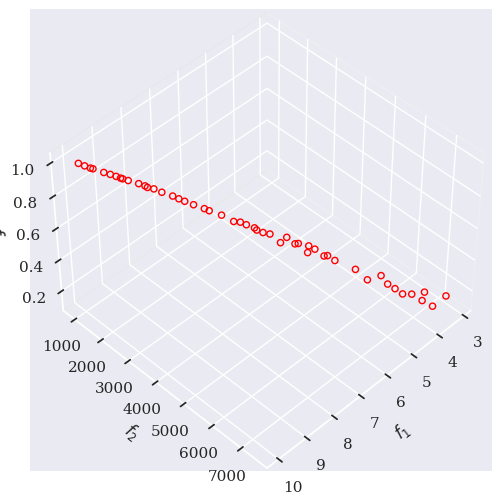

In [ ]:
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

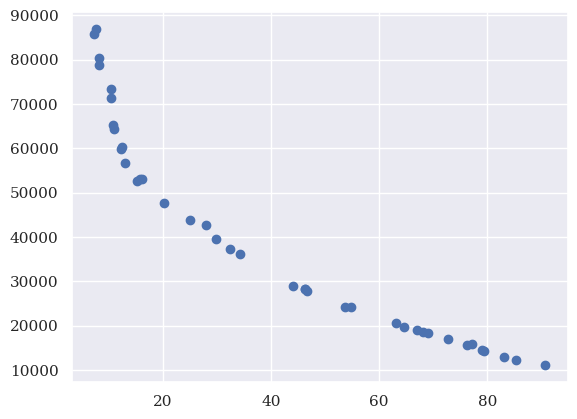

In [ ]:
import matplotlib.pyplot as plt  
import seaborn as sns
df=pd.read_csv("results4.csv")

df=df[df["Gen"]==N_GEN]
df = df[df["total_co2"]!=1000000000]
plt.scatter(x= df["total_co2"], y= df["total_system_costs"])



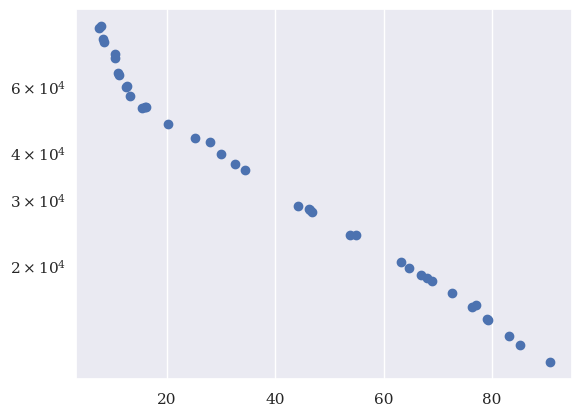

In [ ]:
plt.scatter(x= df["total_co2"], y= df["total_system_costs"])
plt.yscale("log")
#plt.xscale("log")
